In [1]:
from os.path import dirname, abspath,join
import sys
import numpy as np
import pandas as pd
import json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import List
import re, os, json
from os import makedirs
from torchmetrics.regression import R2Score, MeanSquaredError, MeanAbsoluteError

root_path = dirname(abspath("./"))
import sys
sys.path.append(root_path)
from proT.evaluation.predict import *
from proT.evaluation.metrics import compute_prediction_metrics
from notebooks.lib import plot_predictions_enhanced, plot_predictions


# plotting standard settings
plt.rcParams['figure.dpi'] = 100 #360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette('colorblind'))
plt.rcParams['lines.linewidth'] = 2.0

datadir_path    = r"../data/input"

S6 Mamba backend: mamba-pytorch (pure PyTorch fallback)


# Lib

In [2]:
def get_config_and_best_checkpoint(exp_path):
    
    # get config
    config_regex = re.compile("config")
    best_trial_regex = re.compile("best_trial")
    
    config_list = []
    summary_list = []
    for file in os.listdir(exp_path):
        
        if config_regex.match(file):
            config_list.append(file)
                
        elif best_trial_regex.match(file):
            summary_list.append(file)
    
    if len(config_list) != 1:
        raise ValueError(f"More (or none) than one config found! {config_list}")
    else:
        config = OmegaConf.load(os.path.join(exp_path, config_list[0]))
    if len(summary_list) != 1:
        raise ValueError(f"More (or none) than one config found! {summary_list}")
    else:
        summary = OmegaConf.load(os.path.join(exp_path, summary_list[0]))
        
    # get BCE (best checkpoint ever ^^)
    optuna_dir = os.path.join(exp_path, "optuna")
    assert os.path.exists(optuna_dir), AssertionError("Optuna folder doesn't exixt!")
    
    run_dir = os.path.join(optuna_dir, f"run_{summary.trial_number}")
    
    with open(os.path.join(run_dir, "kfold_summary.json")) as f:
        kfold_summary = json.load(f)
    
    
    best_checkpoint_path = os.path.join(
        run_dir,
        f"k_{kfold_summary["best_fold"]["fold_number"]}",
        "checkpoints",
        "best_checkpoint.ckpt"
    )
        
        
    return config, best_checkpoint_path

# Src

## Seq2Seq Prediction

In [3]:
# select experiment
experiment_path     = r"../experiments/baseline_optuna/euler/baseline_proT_dyconex_sum_50908169"

config, checkpoint_path = get_config_and_best_checkpoint(experiment_path)
results = predict_test_from_ckpt(
    config, 
    datadir_path, 
    checkpoint_path, 
    None,
    dataset_label="test",
    cluster=False
    )

Seed set to 42
c:\Users\ScipioneFrancesco\Documents\Projects\proT\myenv\Lib\site-packages\torch\__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:85.)
  _C._set_float32_matmul_precision(precision)


Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Test dataset selected.
Predicting...


100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


## Simulator

In [4]:
# select experiment
experiment_path_sim     = r"../experiments/baseline_optuna/euler/baseline_proTPhySim_dyconex_sum_51773931"

config_sim, checkpoint_path_sim = get_config_and_best_checkpoint(experiment_path_sim)
results_sim = predict_test_from_ckpt(
    config_sim, 
    datadir_path, 
    checkpoint_path_sim, 
    None,
    dataset_label="test",
    cluster=False
    )

Seed set to 42


✓ SimulatorForecaster initialized with model: D
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Test dataset selected.
Predicting...


100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


In [5]:
groups = results.inputs[:,0,0]

df_ds_metrics = pd.read_parquet("../../proT_pipeline/data/builds/dyconex_251117/output/sample_metrics.parquet")

df_metrics = None
results_list = [(results, "Seq-to-Seq"), (results_sim, "Simulator")]

for result, label in results_list:
    df_metrics_temp = compute_prediction_metrics(result, target_feature_idx=config.data.features.Y.value)
    df_metrics_temp["group"] = groups
    df_metrics_temp["head"] = label
    if df_metrics is None:
        df_metrics = df_metrics_temp
    else:
        df_metrics = pd.concat([df_metrics,df_metrics_temp], axis=0)

df = df_metrics.merge(df_ds_metrics, on= "group", how="left")
df["rarity_nan_fraction_target"] += 0.02* np.random.randn(len(df))
df["rarity_last_value"] += 0.02* np.random.randn(len(df))
df

Exception in thread QueueFeederThread:
Exception ignored in: <function _ConnectionBase.__del__ at 0x0000025C17440400>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\connection.py", line 133, in __del__
    self._close()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\queues.py", line 257, in _feed
    reader_close()
    ~~~~~~~~~~~~^^
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2544.0_x64__qbz5n2kfra8p0\Lib\multiprocessing\connection.py", line 178, in close
    self._close()
    ~~~~~~~~~~~^^
  File

,index,R2,MSE,MAE,RMSE,group,head,rarity_last_value,rarity_nan_fraction_input,rarity_nan_fraction_target
0,0,0.721478,0.009243,0.065913,0.096141,877.0,Seq-to-Seq,0.025055,0.000000,0.009934
1,1,0.803310,0.002459,0.041596,0.049588,315.0,Seq-to-Seq,0.036249,0.000801,-0.002765
2,2,0.927538,0.001118,0.028389,0.033433,459.0,Seq-to-Seq,0.014280,0.000801,0.012954
3,3,0.950258,0.000879,0.024412,0.029655,704.0,Seq-to-Seq,-0.011124,0.000801,0.030461
4,4,0.725523,0.006859,0.072502,0.082816,835.0,Seq-to-Seq,0.012773,0.000000,-0.004683
...,...,...,...,...,...,...,...,...,...,...
763,379,0.947095,0.000796,0.024135,0.028217,1224.0,Simulator,-0.034168,0.000801,-0.001921
764,380,0.677600,0.008732,0.089203,0.093447,1169.0,Simulator,0.015987,0.000000,0.022985
765,381,0.912133,0.001397,0.029877,0.037380,1394.0,Simulator,0.007223,0.007163,-0.014064
766,382,-1.383075,0.016153,0.112031,0.127096,1888.0,Simulator,0.001193,0.000801,-0.000700


In [6]:
df.sort_values("MAE", ascending=False)

,index,R2,MSE,MAE,RMSE,group,head,rarity_last_value,rarity_nan_fraction_input,rarity_nan_fraction_target
623,239,-2.553498,0.262177,0.466129,0.512032,1012.0,Simulator,0.309197,0.007873,1.026908
455,71,-25.468155,0.125612,0.338883,0.354418,925.0,Simulator,0.669652,0.000801,-0.015857
71,71,-24.057653,0.118918,0.335330,0.344845,925.0,Seq-to-Seq,0.657096,0.000801,0.030761
239,239,-0.818601,0.134176,0.320383,0.366301,1012.0,Seq-to-Seq,0.335455,0.007873,1.017049
620,236,-451.896057,0.108426,0.294433,0.329281,546.0,Simulator,0.323391,0.000000,-0.015809
...,...,...,...,...,...,...,...,...,...,...
260,260,0.984511,0.000238,0.010127,0.015426,1127.0,Seq-to-Seq,0.012270,0.163443,-0.018539
520,136,0.991631,0.000155,0.009984,0.012452,539.0,Simulator,-0.021009,0.000000,-0.033388
280,280,0.989767,0.000145,0.009609,0.012021,18.0,Seq-to-Seq,0.030589,0.000000,0.002270
129,129,0.992580,0.000108,0.008904,0.010394,399.0,Seq-to-Seq,0.002934,0.000801,-0.010070


In [7]:
# 0. Select head
df_bin = df[df["head"] == "Seq-to-Seq"]

# 1. Bin the data
bins = 100  # Adjust as needed
df_bin["MAE_bin"] = pd.cut(df_bin["MAE"], bins=bins)

# 2. Find the most frequent bin
bin_counts = df_bin["MAE_bin"].value_counts()
most_frequent_bin = bin_counts.idxmax()

# 3. Get the indices of rows in the most frequent bin
indices_in_bin = df_bin.index[df_bin["MAE_bin"] == most_frequent_bin].tolist()

# 4. Randomly sample one index from the most frequent bin
sampled_index = np.random.choice(indices_in_bin)

print("Most frequent bin:", most_frequent_bin)
print("Indices in this bin:", indices_in_bin[:5], "...")
print("Sampled index:", sampled_index)

Most frequent bin: (0.0232, 0.0265]
Indices in this bin: [3, 8, 9, 11, 28] ...
Sampled index: 173


C:\Users\ScipioneFrancesco\AppData\Local\Temp\ipykernel_24440\2717266033.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bin["MAE_bin"] = pd.cut(df_bin["MAE"], bins=bins)


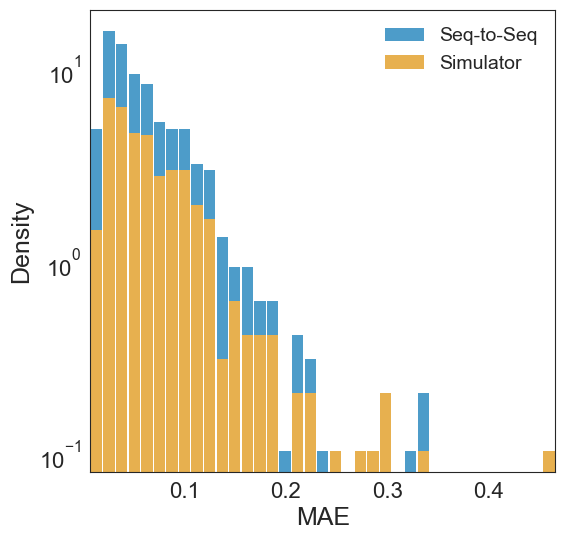

In [19]:
save_dir = "./figures"

fig = plt.figure()
sns.set_style("white")
ax = sns.histplot(
    data=df,
    x="MAE",
    hue = "head",
    edgecolor=None,
    alpha=0.7,
    linewidth=0,
    shrink=0.9,
    multiple="stack",
    legend = True,
    stat="density"
)
legend = ax.get_legend()
if legend:
    legend.set_frame_on(False)
    legend.set_title(None)     

ax.set_yscale("log")
ax.set_xlim(min(df["MAE"]),max(df["MAE"]))

if save_dir is not None:
    makedirs(save_dir, exist_ok=True)
    out_path = join(save_dir, "mae_test_histogram.pdf")
    fig.savefig(out_path, format="pdf", bbox_inches="tight")

plt.show()

### IST Prediction

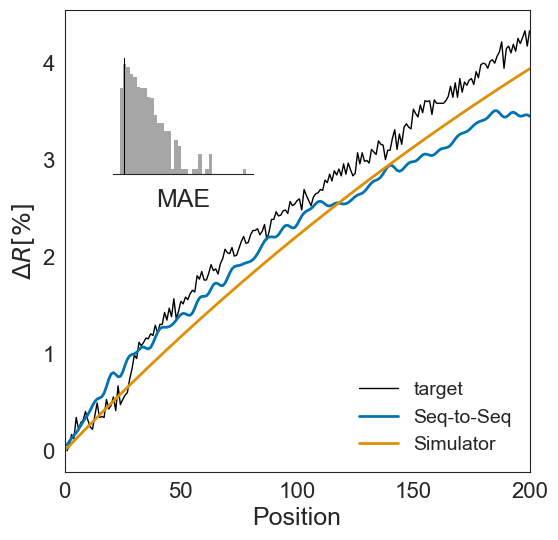

In [9]:
plot_predictions_enhanced(
    sample_id=indices_in_bin[0],
    var_index=config.data.features.Y.variable,
    x_index=config.data.features.Y.position,
    val_index=config.data.features.Y.value,
    target_array=results.targets,
    output_array=[
        (results.outputs, "Seq-to-Seq"),
        (results_sim.outputs, "Simulator"),
    ],
    selected_var=1.0,              # Single variable (no y-axis label)
    mae_df=df_metrics,             # Show distribution
    inset_position='upper left',
    legend_position='lower right',  # Control legend placement
    show_metrics_in_legend=False,
    save_dir=save_dir
)

## Rare Samples

In [10]:
df.sort_values("MAE", ascending=False)

,index,R2,MSE,MAE,RMSE,group,head,rarity_last_value,rarity_nan_fraction_input,rarity_nan_fraction_target
623,239,-2.553498,0.262177,0.466129,0.512032,1012.0,Simulator,0.309197,0.007873,1.026908
455,71,-25.468155,0.125612,0.338883,0.354418,925.0,Simulator,0.669652,0.000801,-0.015857
71,71,-24.057653,0.118918,0.335330,0.344845,925.0,Seq-to-Seq,0.657096,0.000801,0.030761
239,239,-0.818601,0.134176,0.320383,0.366301,1012.0,Seq-to-Seq,0.335455,0.007873,1.017049
620,236,-451.896057,0.108426,0.294433,0.329281,546.0,Simulator,0.323391,0.000000,-0.015809
...,...,...,...,...,...,...,...,...,...,...
260,260,0.984511,0.000238,0.010127,0.015426,1127.0,Seq-to-Seq,0.012270,0.163443,-0.018539
520,136,0.991631,0.000155,0.009984,0.012452,539.0,Simulator,-0.021009,0.000000,-0.033388
280,280,0.989767,0.000145,0.009609,0.012021,18.0,Seq-to-Seq,0.030589,0.000000,0.002270
129,129,0.992580,0.000108,0.008904,0.010394,399.0,Seq-to-Seq,0.002934,0.000801,-0.010070


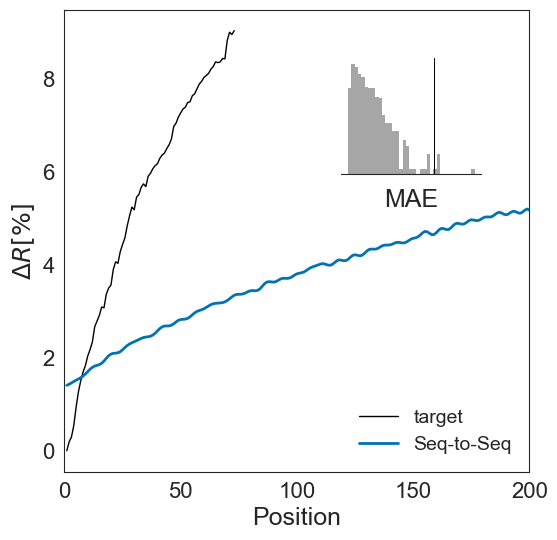

In [11]:
rare_idx = 239

plot_predictions_enhanced(
    sample_id=rare_idx,
    var_index=config.data.features.Y.variable,
    x_index=config.data.features.Y.position,
    val_index=config.data.features.Y.value,
    target_array=results.targets,
    output_array=[
        (results.outputs, "Seq-to-Seq"),
        #(results_sim.outputs, "Simulator"),
    ],
    selected_var=1.0,              # Single variable (no y-axis label)
    mae_df=df_metrics,             # Show distribution
    inset_position='upper right',
    legend_position='lower right',  # Control legend placement
    show_metrics_in_legend=False,
    save_dir=save_dir,
    tag="rare_sample"
)

In [12]:
experiment_path_sim     = r"../experiments/baseline_optuna/euler/baseline_proTCVRand_dyconex_sum_51972551"
config_adp, checkpoint_path_adp = get_config_and_best_checkpoint(experiment_path_sim)

show_trg_max_idx = 10
results_adp = predict_test_from_ckpt_adaptive(
    config_adp, 
    datadir_path, 
    checkpoint_path_adp,
    show_trg_max_idx=show_trg_max_idx,
)

Seed set to 42


✓ OnlineTargetForecaster initialized
  - Target show mode: random
  - Optimizer: AdamW (lr=0.0007000000000000001)
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Loading pre-split data.
Train input shape:  (1526, 1023, 12)
Train target shape:  (1526, 400, 9)
Test input shape:  (394, 1023, 12)
Test target shape:  (394, 400, 9)
Test dataset selected.
Predicting...


100%|██████████| 8/8 [02:00<00:00, 15.02s/it]


AttributeError: 'NoneType' object has no attribute 'lower'

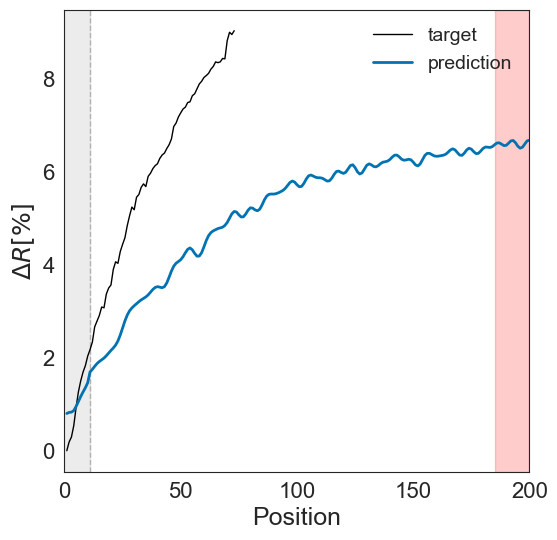

In [ ]:
from lib import plot_predictions_adaptive

plot_predictions_adaptive(
    sample_id=rare_idx, 
    var_index=config.data.features.Y.variable, 
    x_index=config.data.features.Y.position, 
    val_index=config.data.features.Y.value, 
    target_array=results.targets, 
    output_array=results_adp.outputs,
    selected_var=1,
    mae_df=df_metrics,
    inset_position='lower right',
    legend_position='upper right',
    show_metrics_in_legend=True,
    make_title= False,
    title_map=None, 
    save_dir=save_dir, 
    tag=f"adp_{show_trg_max_idx}",
    show_failure = True,  # Toggle failure region visualization
    show_trg_max_idx = show_trg_max_idx,
    )
